# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

# base imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re
import datetime

# spark imports
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, sum, avg, col, count, concat, desc, explode, lit, min, max, split,  isnan, when

from pyspark.sql import Window
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder




In [2]:
# changed working directory

print(os.getcwd())
os.chdir('C:\\Users\\michael.a.hartmann\\Desktop\\sparkify')
print(os.getcwd())

C:\Users\michael.a.hartmann\Dropbox\Data Science Training\Working Directory
C:\Users\michael.a.hartmann\Desktop\sparkify


In [3]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Sparkify Capstone Project") \
    .getOrCreate()

In [4]:
# check session details and access spark UI
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# load dataset

path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [6]:
# Fist look at the schema (columns of the dataset)

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Total rows of dataset

df.count()

286500

In [8]:
# Get insight using describe (count, mean, stddev, min, max)

df.summary().show(vertical=True, truncate=False)

# There seems to be missing data (count)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------
 summary       | count                                                                                                              
 artist        | 228108                                                                                                             
 auth          | 286500                                                                                                             
 firstName     | 278154                                                                                                             
 gender        | 278154                                                                                                             
 itemInSession | 286500                                                                                                             
 lastName      | 278154                                              

In [9]:
# inspect records in detail

df.show(vertical=True, n=2, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------
 artist        | Martha Tilston                                                                                                  
 auth          | Logged In                                                                                                       
 firstName     | Colin                                                                                                           
 gender        | M                                                                                                               
 itemInSession | 50                                                                                                              
 lastName      | Freeman                                                                                                         
 length        | 277.89016                                                                

## Clean Data

In [10]:
# Inspect userId

df.select("userId").dropDuplicates().sort("userId").show(30)

# There seems to be empty strings

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
|100019|
|100021|
|100022|
|100023|
|100024|
|100025|
|   101|
|   102|
|   103|
+------+
only showing top 30 rows



In [11]:
# Count empty strings in userID
df[df.userId == ''].count()

8346

In [12]:
# Exclude empty userID rows
# This is fine since without userID the entries cannot be allocated and are thus of no use.
df_clean = df.filter(df.userId != '')

In [13]:
# check auth column
# 'guest' and 'logged out' values where associated with empty userID

df.select('auth').dropDuplicates().sort('auth').show()
df_clean.select('auth').dropDuplicates().sort('auth').show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [14]:
# quick status on missing values
df_clean.summary().show(n=1, vertical=True)

# it

-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 278154 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 278154 
 lastName      | 278154 
 length        | 228108 
 level         | 278154 
 location      | 278154 
 method        | 278154 
 page          | 278154 
 registration  | 278154 
 sessionId     | 278154 
 song          | 228108 
 status        | 278154 
 ts            | 278154 
 userAgent     | 278154 
 userId        | 278154 
only showing top 1 row



In [15]:
# check columns with missing values
df_clean.select('page').where(df.artist != '').dropDuplicates().show()
df_clean.select('page').where(df.length != 0).dropDuplicates().show()
df_clean.select('page').where(df.song != '').dropDuplicates().show()

df_clean.select('page').where(df.artist != '').count()

+--------+
|    page|
+--------+
|NextSong|
+--------+

+--------+
|    page|
+--------+
|NextSong|
+--------+

+--------+
|    page|
+--------+
|NextSong|
+--------+



228108

In [16]:
# The empty values in artist - song - length columns are limited to the NextSong page.
print(df_clean.count())
print(df_clean.select('page').where(df.page != 'NextSong').count())
print(df_clean.count() - (df_clean.select('page').where(df.artist != '').count() + df_clean.select('page').where(df.page != 'NextSong').count()))

278154
50046
0


In [17]:
# Alternative method to check for missing values, found on Stackoverflow: 
# https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
df_clean.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True, truncate=False)

-RECORD 0--------------
 artist        | 50046 
 auth          | 0     
 firstName     | 0     
 gender        | 0     
 itemInSession | 0     
 lastName      | 0     
 length        | 50046 
 level         | 0     
 location      | 0     
 method        | 0     
 page          | 0     
 registration  | 0     
 sessionId     | 0     
 song          | 50046 
 status        | 0     
 ts            | 0     
 userAgent     | 0     
 userId        | 0     



In [18]:
# Brief look at page values
df.select('page').dropDuplicates().show(truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
+-------------------------+
only showing top 20 rows



In [19]:
# Dataset is now considered cleaned
# No further need to drop missing values for now
# df = df.dropna(how = "any", subset = ['userId', 'sessionId'])

# assign back to df
df = df_clean

## Time

In [20]:
# Convert the timestamp from milliseconds into readable time format
# https://stackoverflow.com/questions/466345/converting-string-into-datetime/466376#466376

to_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%d.%m.%Y %H:%M:%S,%f'))
df = df.withColumn('new_time_stamp', to_datetime('ts'));

In [21]:
df.head(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+--------------------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|      new_time_stamp|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+--------------------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|01.10.2018 02:01:...|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+----------

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [22]:
# Look at authentication and subscription type
df.select('auth').dropDuplicates().show()
df.select('level').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [23]:
# Churn is defined by a user either cancelling his account or by switching from paid to free account.
# Lets verify this

# Find a user who downgraded his subscription
df.filter("page = 'Submit Downgrade'").show(vertical=True, n=1)

# User ID 131

-RECORD 0------------------------------
 artist         | null                 
 auth           | Logged In            
 firstName      | Kael                 
 gender         | M                    
 itemInSession  | 47                   
 lastName       | Baker                
 length         | null                 
 level          | paid                 
 location       | Kingsport-Bristol... 
 method         | PUT                  
 page           | Submit Downgrade     
 registration   | 1533102330000        
 sessionId      | 249                  
 song           | null                 
 status         | 307                  
 ts             | 1538393619000        
 userAgent      | "Mozilla/5.0 (Mac... 
 userId         | 131                  
 new_time_stamp | 01.10.2018 13:33:... 
only showing top 1 row



In [24]:
# By going through the users records, we can find both the upgrade and downgrade event
df.select('userId', 'page', 'status', 'level').where(df.userId == 131).show(n=10000, truncate=False)

+------+----------------+------+-----+
|userId|page            |status|level|
+------+----------------+------+-----+
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |Add to Playlist |200   |free |
|131   |NextSong        |200   |free |
|131   |NextSong        |200   |free |
|131   |Help            |200   |free |
|131   |NextSong        |

In [25]:
# We repeat the same for the 'Cancellation Confirmation' event..
df.filter("page = 'Cancellation Confirmation'").show(vertical=True, n=1)

-RECORD 0------------------------------
 artist         | null                 
 auth           | Cancelled            
 firstName      | Adriel               
 gender         | M                    
 itemInSession  | 104                  
 lastName       | Mendoza              
 length         | null                 
 level          | paid                 
 location       | Kansas City, MO-KS   
 method         | GET                  
 page           | Cancellation Conf... 
 registration   | 1535623466000        
 sessionId      | 514                  
 song           | null                 
 status         | 200                  
 ts             | 1538943990000        
 userAgent      | "Mozilla/5.0 (Mac... 
 userId         | 18                   
 new_time_stamp | 07.10.2018 22:26:... 
only showing top 1 row



In [26]:
# By going through the users records, we can find both the upgrade and downgrade event
df.select('userId', 'page', 'status', 'level').where(df.userId == 18).show(n=52000, truncate=False)

+------+-------------------------+------+-----+
|userId|page                     |status|level|
+------+-------------------------+------+-----+
|18    |Home                     |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |Settings                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |Settings                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |NextSong                 |200   |paid |
|18    |NextSong                 |200   

In [27]:
# As a first step, we add a column to flag customer churn events.

# Define a function to flag the downgrade and cancellation event where:
# 1 for 'Submit Downgrade' or 'Cancel'
# 0 for every other page

flag_churn_event = udf(lambda x: 1 if (x == 'Submit Downgrade' or x == 'Cancellation Confirmation') else 0, IntegerType())

In [28]:
# Apply function to page column and create new column 'churn'
df = df.withColumn('churn', flag_churn_event('page'))

In [29]:
df.head(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+--------------------+-----+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|      new_time_stamp|churn|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+--------------------+-----+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|01.10.2018 02:01:...|    0|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+--

In [30]:
# create a column phase
# define window:sort the values for a user in reverse time order
window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

# add up the values in the churn column
df = df.withColumn('phase', sum('churn').over(window))

In [31]:
# check again for users 131 (downgrade) and 18 (cancel)
df.select(['userId', 'firstname', 'ts', 'page', 'level', 'phase']).where(df.userId == 131).sort('ts').collect()

[Row(userId='131', firstname='Kael', ts=1538384355000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538384770000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538385046000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538385180000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538385402000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538385558000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538386074000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538386309000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538386520000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=1538386726000, page='NextSong', level='free', phase=2),
 Row(userId='131', firstname='Kael', ts=

In [32]:
df.select(['userId', 'firstname', 'ts', 'page', 'level', 'phase']).where(df.userId == 18).sort('ts').collect()

[Row(userId='18', firstname='Adriel', ts=1538499917000, page='Home', level='paid', phase=1),
 Row(userId='18', firstname='Adriel', ts=1538499933000, page='NextSong', level='paid', phase=1),
 Row(userId='18', firstname='Adriel', ts=1538500208000, page='NextSong', level='paid', phase=1),
 Row(userId='18', firstname='Adriel', ts=1538500476000, page='NextSong', level='paid', phase=1),
 Row(userId='18', firstname='Adriel', ts=1538500654000, page='NextSong', level='paid', phase=1),
 Row(userId='18', firstname='Adriel', ts=1538500842000, page='NextSong', level='paid', phase=1),
 Row(userId='18', firstname='Adriel', ts=1538500856000, page='Settings', level='paid', phase=1),
 Row(userId='18', firstname='Adriel', ts=1538501009000, page='NextSong', level='paid', phase=1),
 Row(userId='18', firstname='Adriel', ts=1538501340000, page='NextSong', level='paid', phase=1),
 Row(userId='18', firstname='Adriel', ts=1538501587000, page='NextSong', level='paid', phase=1),
 Row(userId='18', firstname='Adrie

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Considerations for data analysis:
- users and their behavior 
- users who stayed vs users who curned
- systems, browsers and devices used

In [33]:
# create pandas dataframe
df_pd = df.toPandas()

In [34]:
# unique users, male and female
print("Unique users:", df_pd.drop_duplicates(subset=['userId']).userId.count())
print(df_pd.drop_duplicates(subset=['userId']).groupby('gender').userId.count())

Unique users: 225
gender
F    104
M    121
Name: userId, dtype: int64


In [35]:
# total user churn and %
print("Total churns: ", df_pd.churn.sum())
print("Churn rate: ", round((df_pd.churn.sum() / df_pd.drop_duplicates(subset=['userId']).userId.count()) * 100, 2), "%")

df_pd.drop_duplicates(['userId', 'gender']).groupby(['churn', 'gender']).churn.count()

Total churns:  115
Churn rate:  51.11 %


churn  gender
0      F         84
       M         90
1      F         20
       M         31
Name: churn, dtype: int64

In [36]:
# average churn rate per gender
print('female churn rate:', round(20 / 104, 2))
print('male churn rate:', round(31 / 121, 2))

female churn rate: 0.19
male churn rate: 0.26


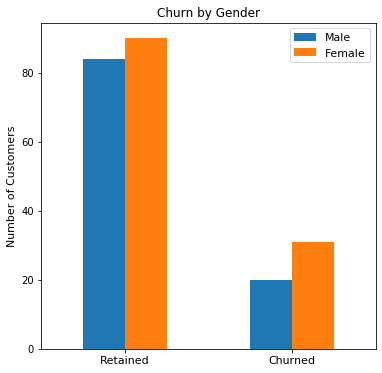

In [37]:
# male and female user churn comparison
gender_churn = df_pd.drop_duplicates(['userId', 'gender']).groupby(['churn', 'gender']).churn.count().unstack()



fig, ax = plt.subplots(figsize=(6, 6));
gender_churn.plot.bar(title='Churn by Gender', ax=ax);
ax.legend(['Male', 'Female'], fontsize=11);
ax.set_xticklabels(['Retained', 'Churned'], fontsize=11);
ax.set_ylabel("Number of Customers", fontsize=11);
ax.set_xlabel("")
plt.xticks(rotation=0);


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
WIP

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [ ]:
WIP

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
WIP